# Terrorism target set generation

_José Roberto Canivete Cuissa_  
_Luigi Bassini_  
_Dorian Quelle_  

Zurich, 14.05.2023

The aim of this project is to predict if a building with specific features is likely to be targeted in a terrorist attack by analyzing a selected list of buildings that have been attacked in the past. To achieve this, the proposed approach involves using the OpenAI GPT-3.5 model to rate the importance of certain features for a given building at a specific year in the past. The past events are exctracted from the Global Terrorism Database (https://www.kaggle.com/datasets/START-UMD/gtd). Then, a machine learning model will be trained using the generated dataset to make predictions.


### Requirements

- openai
- numpy
- pandas
- matplotlib
- shap
- scikit-learn

To use the OpenAI API, the library needs a valid account's secret key. Visit https://platform.openai.com/ to create an account and generate a secret key. 

-----------

## Imports

In [25]:
import openai
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os.path
import shap
import pickle
from tenacity import retry

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


#------------
# INSERT YOUR OPENAI API KEY HERE
OPENAI_API_KEY = "...TO_BE_FILLED..."
#------------ 
openai.api_key  = OPENAI_API_KEY


----------------

## List of features (for the GPT prompt)

In [7]:
# List of features that could be relevant for a terrorist attack
features = {}
features['Accessibility']   = f"""Is the building easily accessible? \n
                                Is it easy for someone to get to the building from their origin, \n
                                e.g. via major roads, public transportation, etc.? \n
                                """
features['Security']        = f"""Is the building guarded by police or military personnel. \n
                                Does the building has any form of controls/screening at the entrance? \n 
                                Is it easy to get into the building without getting particular attention?
                                """
features['Religion']        = f"""Is the building relevant for any religion? \n
                                Does the building contain important religious objects or people?
                                """
features['Politics']        = f"""Is the building relevant from a political point of view? \n  
                                """
features['Crowds']          = f"""Is the building typically crowded? \n
                                Does it host events which attract large amounts of people? \n
                                """
features['Culture']         = f"""Is the building valuable/symbolic for the culture of the population? \n
                                """
features['Cost']            = f"""Is the building valuable from a financial point of view? \n
                                Is it expensive to build or maintain? \n
                                """
features['History']         = f"""Is the building relevant from a historical point of view? \n
                                Does it host important historical objects or events? \n
                                """
features['Media']           = f"""Is the building relevant for the media? \n
                                Does it host important media companies or events? \n
                                """
features['Tourism']         = f"""Is the building relevant for tourism? \n
                                Does it host important tourist attractions? \n
                                """
features['Education']       = f"""Is the building relevant for education? \n
                                Does it host important educational institutions? \n
                                """
features['Health']          = f"""Is the building relevant for health? \n
                                Does it host important health institutions? \n
                                """
features['Sports']          = f"""Is the building relevant for sports? \n
                                Does it host important sports events? \n
                                """
features['Transportation']  = f"""Is the building relevant for transportation? \n
                                Does it host important transportation hubs? \n
                                """
features['Infrastructure']  = f"""Is the building relevant for the infrastructure of the city/country/region? \n
                                Does it host important infrastructure objects? \n
                                """
features['Military']        = f"""Is the building relevant for the military? \n
                                Does it host important military objects? \n
                                """
features['Government']      = f"""Is the building relevant for the government? \n	
                                Does it host important government institutions? \n
                                """
features['Business']        = f"""Is the building relevant for the business community? \n
                                Does it host important companies or business events? \n
                                Its distruction would have a negative impact on the economy?
                                """
features['Population']      = f"""Is the building located in a highly populated region/city? \n
                                """

# List of feature names 
features_names = list(features.keys())

------------------

## Building feature ratings with GPT 3.5

In [8]:
@retry
def get_completion(prompt, model="gpt-3.5-turbo"):
    # Get completion routine from OpenAI
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

def create_prompt(building, city, year, features, short=True, attack=1):
    # Generate the prompt for the GPT model based on the list of features
    prompt = 'You will be given the name of a building, the city where this building is located, and a year.\n'
    prompt += 'Please estimate as precisely as you can each of the following features of the building from 1 to 20 in before the year indicated,: \n'
    for key in features.keys():
        prompt += (key + ' : ' + features[key] + '\n')
    prompt += 'The answer should be given in a JSON format with the given features as keys, \n'
    if short:
        prompt += 'and the score between 1 and 20 as value.\n'
    else:
        prompt += 'then a list containing two entries: 1. The score between 1 and 20, 2. a brief description explaining your reasoning.\n'
    prompt += "Add one entry to the JSON output with key 'Attack' and value " + str(attack) + ".\n"
    prompt += 'The name of the building is: ' + building + '\n'
    prompt += 'The building is in: ' + city + '\n'
    prompt += 'The year is: ' + str(year) + '\n'
    return prompt

def generate_score_building(building, city, year, features, short, attack):
    # Run the GPT model to generate the score for a building
    prompt = create_prompt(building, city, year, features, short, attack)
    response = get_completion(prompt)
    return eval(response)

def get_similar_buildings(building, city, n=2):
    # Ask GPT for similar buildings in the same city of the target building
    prompt = "Return a list of "+str(n)+" real buildings in "+str(city)+".\n"
    prompt += "If you cannot find "+str(n)+" real buildings, return as many as possible. \n"
    prompt += "If "+str(building)+" is in the list, remove it. \n"
    prompt += "Format the answer as a JSON outpu with the names of the buildings. \n"
    response = get_completion(prompt)
    response = eval(response)
    return response['buildings']

def create_building_dataset(building, city, year, features, short=True):
    # Create a dataset of scores for a building and similar buildings
    database = {}
    score = generate_score_building(building, city, year, features, short, attack=1)
    database[building+','+city] = score
    similar_buildings = get_similar_buildings(building, city)
    for sim_building in similar_buildings:
        score_b = generate_score_building(sim_building, city, year, features, short, attack=0)
        database[sim_building+','+city] = score_b
    return database

#### Example 1: 

Generate the scores for the Prime Tower in Zurich for the year 2015


Accessibility : 18
Security : 16
Religion : 1
Politics : 5
Crowds : 12
Culture : 8
Cost : 20
History : 1
Media : 10
Tourism : 10
Education : 1
Health : 1
Sports : 1
Transportation : 18
Infrastructure : 18
Military : 1
Government : 16
Business : 20
Population : 20
Attack : 1


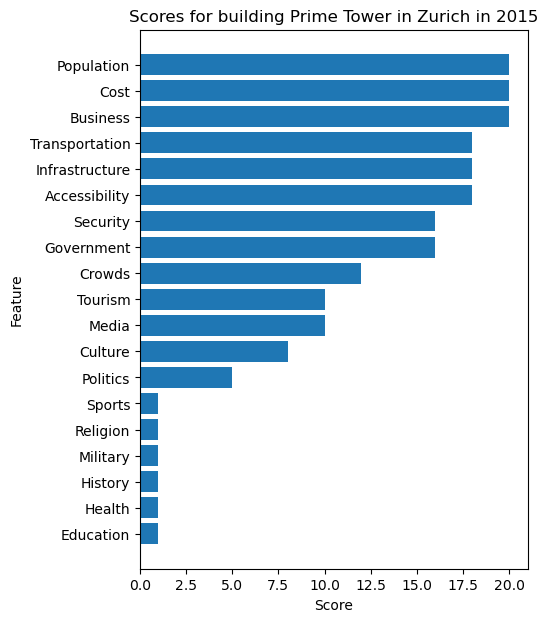

In [10]:
building = 'Prime Tower'
city = 'Zurich'
year = 2015
response = generate_score_building(building, city, year, features, True, 1)

# Print the dictionary in a nice format
def print_dict(dictionary):
    for key in dictionary.keys():
        print(key + ' : ' + str(dictionary[key]))
        
print_dict(response)

# Plot with a bar chart
# Get keys and values without 'attack' key  
keys = list(response.keys())
keys.remove('Attack')
values = list(response.values())
values  = values[:len(values)-1]

# Order keys and values from highest to lowest value
values, keys = zip(*sorted(zip(values, keys), reverse=False))

# Plot the bar chart in horitzontal orientation
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 7))
plt.barh(keys, values)
plt.title('Scores for building ' + building + ' in ' + city + ' in ' + str(year))
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()


#### Example 2

Generate the scores for the JFK international airport in different years 


Accessibility : 15 | 15
Security : 10 | 18
Religion : 1 | 1
Politics : 1 | 3
Crowds : 18 | 20
Culture : 5 | 5
Cost : 17 | 17
History : 3 | 10
Media : 5 | 8
Tourism : 20 | 20
Education : 1 | 1
Health : 1 | 3
Sports : 5 | 5
Transportation : 20 | 20
Infrastructure : 20 | 20
Military : 1 | 1
Government : 1 | 5
Business : 18 | 18
Population : 20 | 20
Attack : 1 | 1


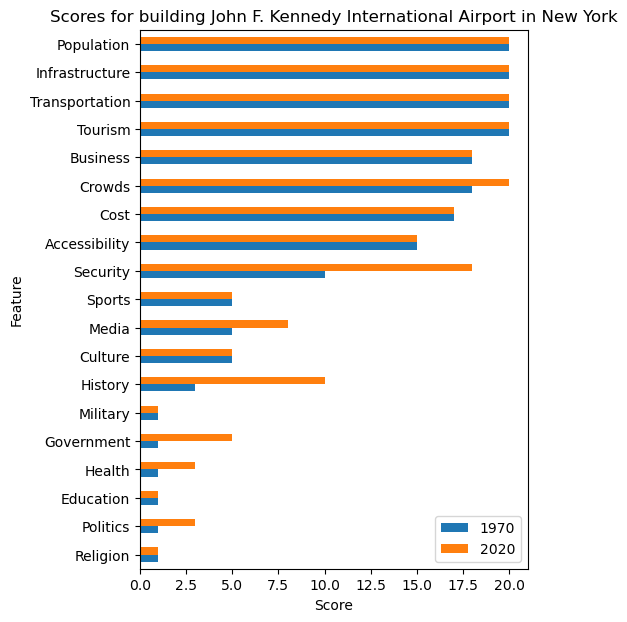

In [15]:
building = 'John F. Kennedy International Airport'
city = 'New York'
year1 = 1970
year2 = 2020
response1 = generate_score_building(building, city, year1, features, True, 1)
response2 = generate_score_building(building, city, year2, features, True, 1)
# Print the two dictionaries in a nice format and compare them in a table
def print_dict_comparison(dictionary1, dictionary2):
    for key in dictionary1.keys():
        print(key + ' : ' + str(dictionary1[key]) + ' | ' + str(dictionary2[key]))

print_dict_comparison(response1, response2)

# Get keys and values without 'attack' key
keys = list(response1.keys())
keys.remove('Attack')
values1 = list(response1.values())
values2 = list(response2.values())
values1  = values1[:len(values1)-1]
values2  = values2[:len(values2)-1]

# Create a dataframe df with the scores for the same building in different years
df = pd.DataFrame({year1: values1, year2: values2}, index=keys)
df = df.sort_values(by=[year1])
df.plot.barh(figsize=(5, 7))
plt.title('Scores for building ' + building + ' in ' + city)
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

#### Example 3

Generate the scores for one building targeted by a terrorist attack and other two buildings in the same city that were not attacked

In [17]:
# Example of usage 3: generate a dataset of scores for a building and similar buildings 
database = create_building_dataset('La Rigoletta restaurant', 'Palma de Maiorca', 2009, features)
# Print the dictionary of each entry in the database in a nice format and compare them in a table
def print_database(database):
    for key in database.keys():
        print(key + ' : ' + str(database[key]))

print_database(database)

La Rigoletta restaurant,Palma de Maiorca : {'Accessibility': 15, 'Security': 10, 'Religion': 1, 'Politics': 1, 'Crowds': 10, 'Culture': 10, 'Cost': 10, 'History': 5, 'Media': 1, 'Tourism': 15, 'Education': 1, 'Health': 1, 'Sports': 1, 'Transportation': 10, 'Infrastructure': 10, 'Military': 1, 'Government': 1, 'Business': 15, 'Population': 20, 'Attack': 1}
Cathedral of Santa Maria of Palma,Palma de Maiorca : {'Accessibility': 15, 'Security': 10, 'Religion': 20, 'Politics': 5, 'Crowds': 15, 'Culture': 20, 'Cost': 18, 'History': 20, 'Media': 5, 'Tourism': 20, 'Education': 5, 'Health': 5, 'Sports': 5, 'Transportation': 5, 'Infrastructure': 5, 'Military': 5, 'Government': 5, 'Business': 5, 'Population': 20, 'Attack': 0}
Bellver Castle,Palma de Maiorca : {'Accessibility': 10, 'Security': 5, 'Religion': 5, 'Politics': 3, 'Crowds': 7, 'Culture': 15, 'Cost': 12, 'History': 18, 'Media': 2, 'Tourism': 20, 'Education': 2, 'Health': 1, 'Sports': 3, 'Transportation': 5, 'Infrastructure': 10, 'Milita

---------------------

## Run GPT-3.5 on selected terroristic events 

The list of selected events corresponds to the events from the Global Terrorism Database which satisfied the following criteria:

- Event took place in North America, Europe, or East Asia
- At least one wounded or one killed
- A summary of the event is present (from where we can infer the information about the building)

The selected events are saved in the "events.csv" file used below.

In [18]:
# read the dataset
events = pd.read_csv("events.csv")
events.head()

,id,city,country,gname,location,summary
0,63.0,Berkeley,United States,Black Nationalists,Berkeley police station,1970
1,148.0,New York City,United States,Black Panthers,Electric Circus Discotheque,1970
2,187.0,Freeport,United States,Unknown,Dow Chemical Company,1970
3,209.0,Lawrence,United States,Student Radicals,"Student Union, University of Kansas",1970
4,248.0,New Haven,United States,Student Radicals,"Ingalls Skating Rink, Yale University",1970


In [19]:
def create_features_dataset(events, features):
    # Given a dataset of events with the columns: location, city, year and a list of features, 
    # create a dataset of scores for each event and save it in a csv file

    # Define name of columns
    name_of_columns = ['index', 'building', 'city', 'year'] + list(features.keys()) + ['attack']

    # Check if csv file exists
    import os.path
    if not os.path.isfile("features_of_events.csv"):
        # create a new pandas dataframe with columns: building, city, year, accessibility, security, religion, politics, crowds, value, business, population, attack
        df = pd.DataFrame(columns=name_of_columns)
        last_index = -1
    else:
        # load the file as a pandas dataframe
        df = pd.read_csv("features_of_events.csv")
        # get last index of the dataframe
        last_index = df['index'].max()


    # iterate over the events dataframe starting from last index
    for index, row in events.iterrows():
        if index <= last_index:
            continue
        building = row['location'] 
        city = row['city']
        year = row['summary']
        # get the score for each event
        print(index,':',building, city, year)
        event_db = create_building_dataset(building, city, year, features)
        for key in event_db.keys():
            # Add a new row in the dataframe df with the values of the event
            dict_to_append = {'index':index, 'building': key.split(',')[0], 'city': key.split(',')[1], 'year': year}
            for key_features in features.keys():
                dict_to_append[key_features] = event_db[key][key_features]
            dict_to_append['attack'] = event_db[key]['Attack']
            df = df.append(dict_to_append, ignore_index=True)
            # save the dataframe df to a csv file  
            df.to_csv('features_of_events.csv', index=False)


The above function generates a dataset of scores for each event in the events dataset. It takes ~1 hour to run. We have already run it and saved the results in the file features_of_events.csv. We will load it in the next cell. If you want to run it anyway, uncomment the next cell.

In [ ]:
# create_features_dataset(events, features)

In [20]:
# Read the dataset a show a sample
df = pd.read_csv("features_of_events.csv")
df.head()

,index,building,city,year,Accessibility,Security,Religion,Politics,Crowds,Culture,...,Education,Health,Sports,Transportation,Infrastructure,Military,Government,Business,Population,attack
0,0,Berkeley police station,Berkeley,1970,15,10,1,10,5,5,...,1,1,1,10,10,10,15,5,20,1
1,0,Sather Tower,Berkeley,1970,15,10,5,5,10,15,...,15,5,5,10,10,5,15,5,20,0
2,0,Berkeley Art Museum and Pacific Film Archive,Berkeley,1970,15,10,5,5,10,15,...,15,5,5,10,10,5,10,5,20,0
3,1,Electric Circus Discotheque,New York City,1970,15,5,1,1,20,20,...,1,1,1,15,10,1,1,15,20,1
4,1,Empire State Building,New York City,1970,20,10,1,5,15,20,...,1,1,10,20,20,1,20,20,20,0


----------------------

## Train the KNN model 

In [22]:
# read the dataset
data = pd.read_csv("features_of_events.csv")
# collect the names of the features
features_names = list(data.columns[4:-1])

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(data[features_names], data['attack'], test_size=0.2, random_state=42)


In [23]:
# Parameters for the KNN classifier
n_neighbors = 5
weights = 'distance'

# Create the KNN classifier
knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
knn_model = knn.fit(X_train, y_train)

# Predict the test set
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)

# Save the model as a pickle file
pickle.dump(knn_model, open('knn_model.pkl', 'wb'))

Confusion_matrix:
[[25  2]
 [ 9 11]]
---------------------------------
Classification_report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        27
           1       0.85      0.55      0.67        20

    accuracy                           0.77        47
   macro avg       0.79      0.74      0.74        47
weighted avg       0.78      0.77      0.75        47



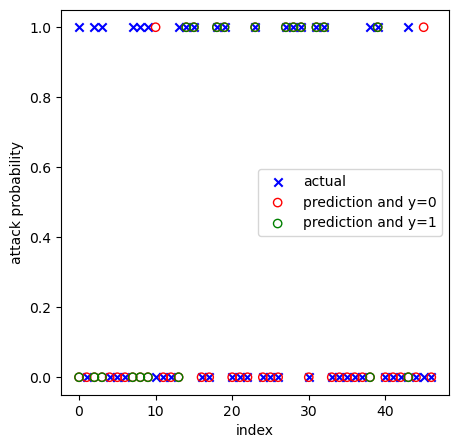

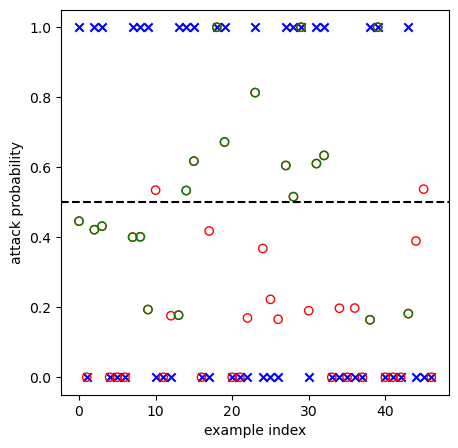

In [24]:
# Analyze the results
print('Confusion_matrix:')
print(confusion_matrix(y_test, y_pred))
print('---------------------------------')
print('Classification_report:')
print(classification_report(y_test, y_pred))

# Plot the results 1 or 0
plt.figure(figsize=(5,5))
x = np.arange(0, len(y_test))
plt.scatter(x,y_test, color='blue', label='actual', marker='x')
plt.scatter(x,y_pred, color='red', label='prediction and y=0', marker='o', facecolors='none')
# mask where the prediction is 1
mask = y_test == 1
plt.scatter(x[mask],y_pred[mask], label='prediction and y=1', color='green', marker='o', facecolors='none')
# put labels
plt.xlabel('index')
plt.ylabel('attack probability')
plt.legend()
plt.show()

# Plot the results probability
plt.figure(figsize=(5,5))
x = np.arange(0, len(y_test))
plt.scatter(x,y_test, color='blue', label='actual', marker='x')
plt.scatter(x,y_pred_proba[:,1], color='red', label='prediction and y=0', marker='o', facecolors='none')
# mask where the prediction is 1
mask = y_test == 1
plt.scatter(x[mask],y_pred_proba[:,1][mask], label='prediction and y=1', color='green', marker='o', facecolors='none')
# put labels
plt.xlabel('example index')
plt.ylabel('attack probability')
# put a horizontal line at 0.5  
plt.axhline(y=0.5, color='black', linestyle='--')
#plt.legend(loc='best')
plt.show()

----------------------------

## 5. Train a Random Forest Classifier to predict the attack

In [26]:
# read the dataset
data = pd.read_csv("features_of_events.csv")
# collect the names of the features
features_names = list(data.columns[4:-1])

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(data[features_names], data['attack'], test_size=0.2, random_state=42)

In [27]:
# Parameters for the Random forest classifier
n_neighbors = 5
weights = 'distance'

# Create the Random Forest classifier
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model = rf.fit(X_train, y_train)

# Predict the test set
y_pred = rf_model.predict(X_test)

# Save the model as a pickle file
pickle.dump(rf_model, open('rf_model.pkl', 'wb'))

Confusion_matrix:
[[26  1]
 [ 6 14]]
---------------------------------
Classification_report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        27
           1       0.93      0.70      0.80        20

    accuracy                           0.85        47
   macro avg       0.87      0.83      0.84        47
weighted avg       0.86      0.85      0.85        47



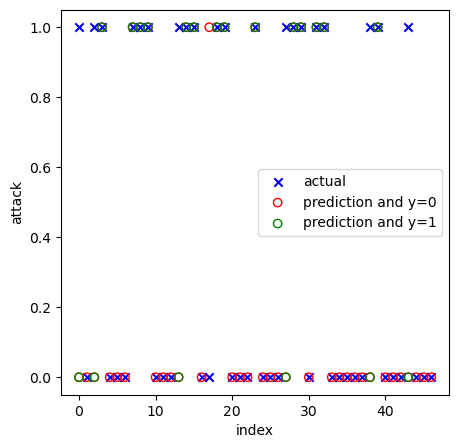

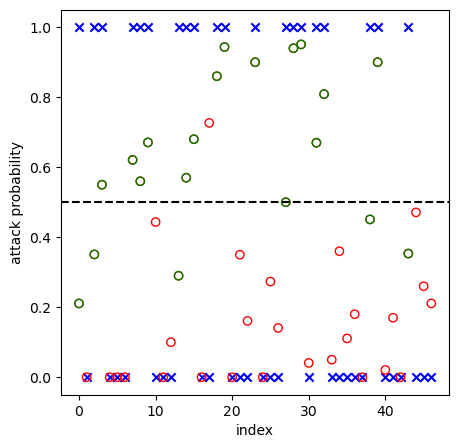

In [28]:
# Analyze the results of the Random Forest
print('Confusion_matrix:')
print(confusion_matrix(y_test, y_pred.round()))
print('---------------------------------')
print('Classification_report:')
print(classification_report(y_test, y_pred.round()))

# create an array with the predictions rounded to 0 or 1
y_pred_binary = y_pred.round()

# Plot the results 1 or 0
plt.figure(figsize=(5,5))
x = np.arange(0, len(y_test))
plt.scatter(x,y_test, color='blue', label='actual', marker='x')
plt.scatter(x,y_pred_binary, color='red', label='prediction and y=0', marker='o', facecolors='none')
# mask where the prediction is 1
mask = y_test == 1
plt.scatter(x[mask],y_pred_binary[mask], label='prediction and y=1', color='green', marker='o', facecolors='none')
# put labels
plt.xlabel('index')
plt.ylabel('attack')
plt.legend()
plt.show()


# Plot the results probability
plt.figure(figsize=(5,5))
x = np.arange(0, len(y_test))
plt.scatter(x,y_test, color='blue', label='actual', marker='x')
plt.scatter(x,y_pred, color='red', label='prediction and y=0', marker='o', facecolors='none')
# mask where the prediction is 1
mask = y_test == 1
plt.scatter(x[mask],y_pred[mask], label='prediction and y=1', color='green', marker='o', facecolors='none')
# put labels
plt.xlabel('index')
plt.ylabel('attack probability')
# put a horizontal line at 0.5  
plt.axhline(y=0.5, color='black', linestyle='--')
#plt.legend(loc='upper right')
plt.show()

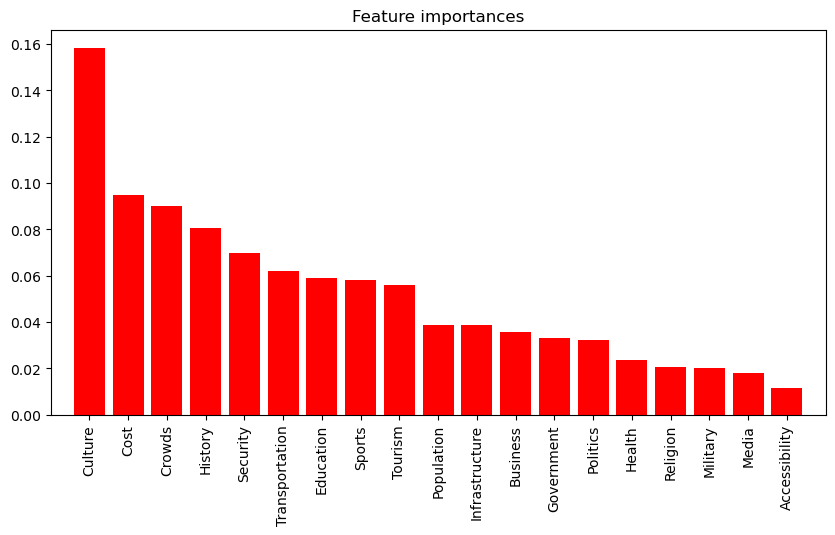

In [29]:
# Check the importance of the features
sorted(zip(rf_model.feature_importances_, features_names), reverse=True)
# Order and plot the features by importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), np.array(features_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()



--------------------

## Try model on list of relevant buildings in Switzerland

In [30]:
def prepare_array_for_predict_model(response):
    # From a dictionary of scores, create an array that can be used as input for the model
    # The order of the features is the same as in the dictionary
    array = np.zeros(len(response.keys())-1)
    i = 0
    for key in response.keys():
        if key != 'Attack':
            array[i] = response[key]
        i+=1
    return array

We asked GPT-3.5 to come up with the 50 most relevant buildings in Switzerland. 
The list is saved in 'list_of_buildings_switzerland.pkl' 

In [31]:
# Load list of relevant buildings (pickle file)
relevant_buildings = pickle.load(open('list_of_buildings_switzerland.pkl', 'rb'))
# transform the list into a pandas dataframe
relevant_buildings = pd.DataFrame(relevant_buildings, columns=['name', 'city'])
relevant_buildings.tail(10)

,name,city
40,Zurich University of Applied Sciences,Zurich
41,University of Basel,Basel
42,University of Geneva,Geneva
43,University of Lausanne,Lausanne
44,University of Bern,Bern
45,Zurich University of the Arts,Zurich
46,University of St. Gallen,St. Gallen
47,University of Fribourg,Fribourg
48,University of Neuchatel,Neuchatel
49,University of Lugano,Lugano


In [21]:
def create_building_dataset_switzerland():
    # Check if csv file exists
    if not os.path.isfile("features_of_buildings_switzerland.csv"):
        # create a new pandas dataframe with columns: building, city, year, accessibility, security, religion, politics, crowds, value, business, population, attack
        features_of_buildings = pd.DataFrame(columns=['name', 'city']+features_names)
        last_index = -1
    else:
        # load the file as a pandas dataframe
        features_of_buildings = pd.read_csv("features_of_buildings_switzerland.csv")
        # get last index of the dataframe
        last_index = features_of_buildings['index'].max()


    # iterate over the events dataframe starting from last index
    for index, row in relevant_buildings.iterrows():
        if index <= last_index:
            continue
        # run the generate_score_building function for each building
        response = generate_score_building(row['name'], row['city'], year=2023, features=features, short=True, attack=0)
        # prepare the array for the model
        array = prepare_array_for_predict_model(response)
        features_of_buildings.loc[index] = [row['name'], row['city']] + list(array)

        # Save the dataset as a csv file
        features_of_buildings.to_csv('features_of_buildings_switzerland.csv')

The above function will take a while to run. It will generate a csv file with the features of the buildings in Switzerland. The file will be used to predict the probability of an attack for each building. 
We already run it and saved the output in 'features_of_buildings_switzerland.csv'. If you want to run it for yourself, uncomment the following cell.

In [33]:
#create_building_dataset_switzerland()

In [34]:
# load the KNN model
knn_model = pickle.load(open('knn_model.pkl', 'rb'))
# load the RF model
rf_model = pickle.load(open('rf_model.pkl', 'rb'))
# Load the building dataset
features_of_buildings = pd.read_csv("features_of_buildings_switzerland.csv")
# prepare the array for the model (only the columns with the features)
array = features_of_buildings[features_names]
# predict the attacks with the KNN model
y_pred_knn = knn_model.predict_proba(array)
# predict the attacks with the RF model
y_pred_rf = rf_model.predict(array)
# prepare array with name of the buildings and the city
model_predictions = features_of_buildings[['name', 'city']]
# Append two columns with the predictions of KNN and RF 
model_predictions['knn'] = y_pred_knn[:,1]
model_predictions['rf'] = y_pred_rf
# save the predictions as a csv file
model_predictions.to_csv('model_predictions_switzerland.csv')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


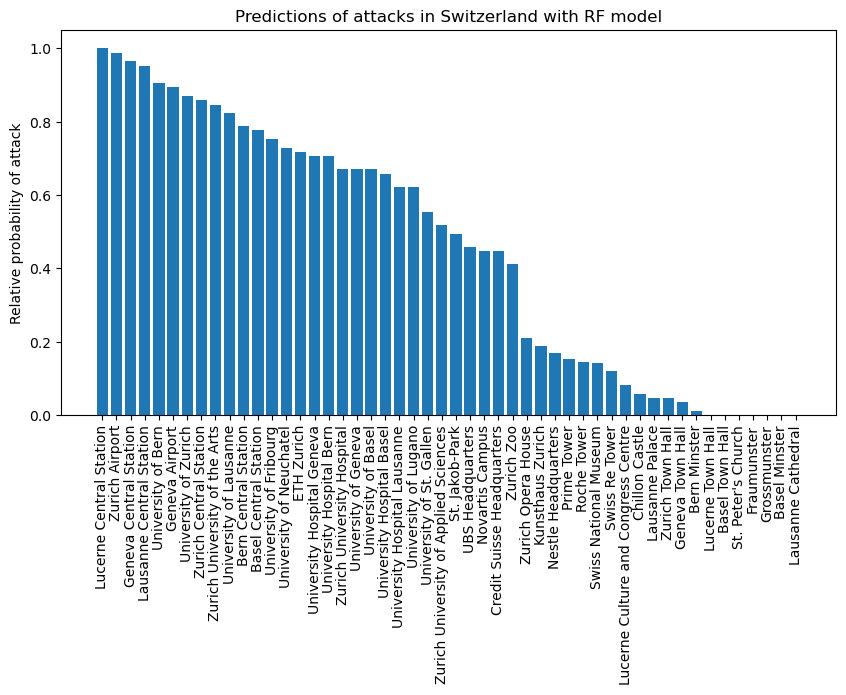

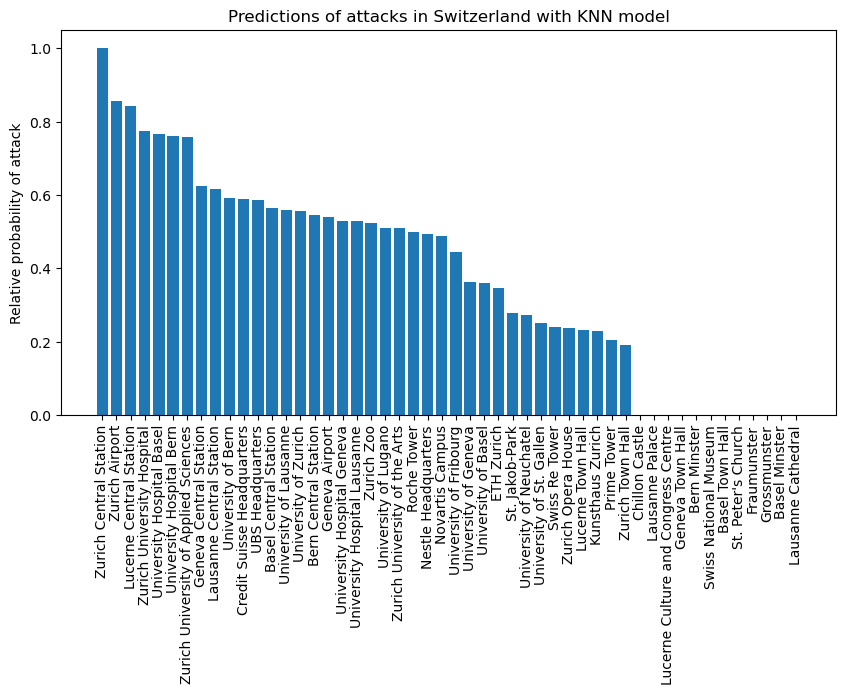

In [35]:
# Visualize the results
model_predictions = pd.read_csv("model_predictions_switzerland.csv")
# sort the dataframe by the predictions of the RF model
model_predictions = model_predictions.sort_values(by=['rf'], ascending=False)
# plot the results as an histogram with the name of the buildings
plt.figure(figsize=(10,5))
plt.bar(model_predictions['name'], model_predictions['rf']/model_predictions['rf'].max())
plt.title('Predictions of attacks in Switzerland with RF model')
plt.ylabel('Relative probability of attack')
plt.xticks(rotation=90)
plt.show()

# sort the dataframe by the predictions of the RF model
model_predictions = model_predictions.sort_values(by=['knn'], ascending=False)
# plot the results as an histogram with the name of the buildings
plt.figure(figsize=(10,5))
plt.bar(model_predictions['name'], model_predictions['knn']/model_predictions['knn'].max())
plt.title('Predictions of attacks in Switzerland with KNN model')
plt.ylabel('Relative probability of attack')
plt.xticks(rotation=90)
plt.show()



----------------------------------

## Infer the importance of features with SHAP

In [36]:
# load the KNN model
knn_model = pickle.load(open('knn_model.pkl', 'rb'))
# load the RF model
rf_model = pickle.load(open('rf_model.pkl', 'rb'))
# Load the building dataset
features_of_buildings = pd.read_csv("features_of_buildings_switzerland.csv")
# Load the model predictions
model_predictions = pd.read_csv("model_predictions_switzerland.csv")

In [37]:
# compute SHAP values
explainer_rf = shap.Explainer(rf_model, features_of_buildings[features_names])
shap_values = explainer_rf(features_of_buildings[features_names])

In [38]:
shap_values[0]

.values =
array([-0.00063333, -0.00061222, -0.00474881,  0.01745851, -0.03244103,
        0.01482489, -0.08575133, -0.04717268,  0.00689037,  0.05169119,
       -0.055558  , -0.00454   ,  0.00935815, -0.00082   , -0.0586649 ,
       -0.04487214, -0.01124246, -0.02277111,  0.00292111])

.base_values =
0.39001714285714306

.data =
array([18., 16.,  1.,  3., 12.,  6., 20.,  1.,  4., 10.,  2.,  2.,  3.,
       18., 18.,  1., 16., 20., 20.])

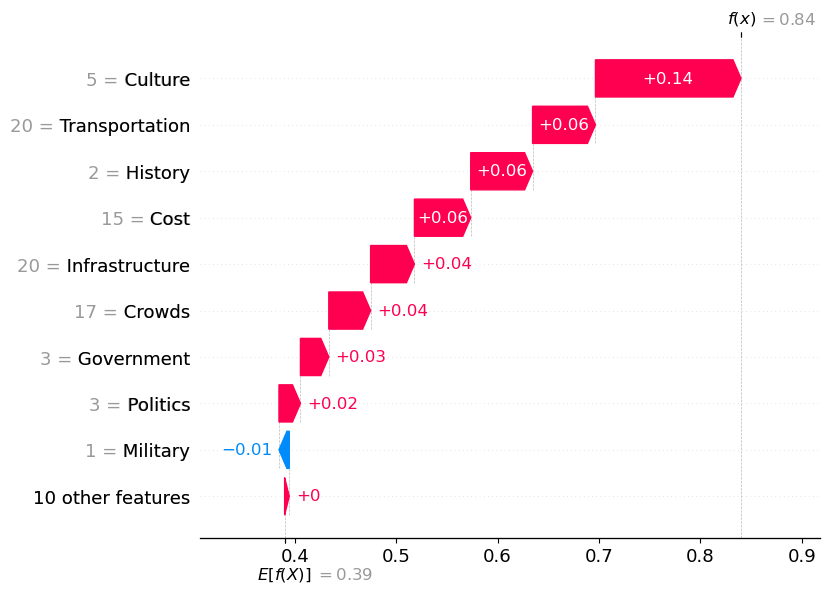

In [39]:
shap.plots.waterfall(shap_values[7], max_display=10)


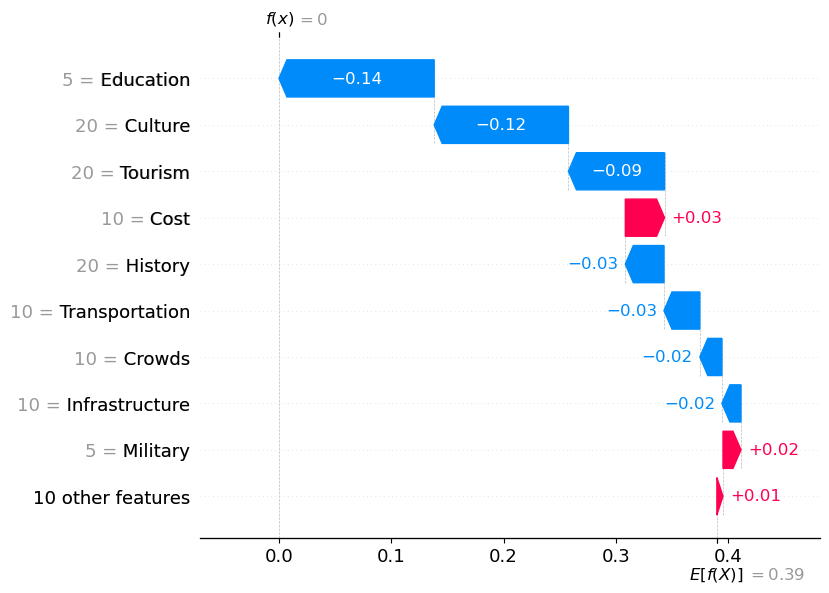

In [40]:
shap.plots.waterfall(shap_values[24], max_display=10)


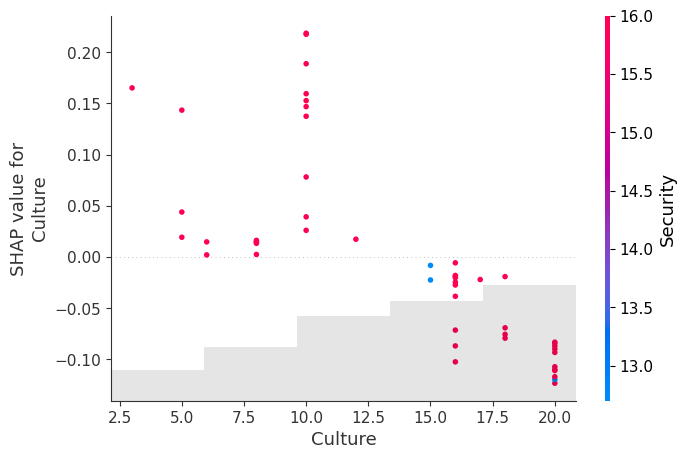

In [41]:
shap.plots.scatter(shap_values[:,"Culture"], color=shap_values[:,"Security"])